# The RBM flow and the Critical Temperature of Ising Models

This notebook contains the main discussion for $L=100$.

First, we import the necessary Python packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import time

import torch
import torch.nn as nn
torch.manual_seed(12)

import sys
sys.path.append('/modules')

from modules.mc_ising2d import IsingMC
from modules.mc_ising2d_MF import IsingMC as IsingMC_MF
from modules.net import Net
from modules.rbm import RBM

L = 100
Tc_Ons = 2 / ( np.log(1 + np.sqrt(2)) )
Tc_MF = 4.0

The neural network thermometer is called by the following function.

In [2]:
def thermometer(flow_,
                ising_data,
                L= 100,
                x= 0,
                step= 2,
                save= False,
                Tzero= True, 
                x_text= 0,
                y_text= 0.15,
                errorbar= True,
                publication= False,
                Tc_MF= False,
                only_last= False,
                training_set= 'COMPLETE',
                loc_legend= 'lower right',
                NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt',
                cpu= False):
    
    if Tc_MF:
        Tc_ = 2*2.0
    else:
        Tc_ = 2 / ( np.log(1 + np.sqrt(2)) )
        
    
    net = Net()
    if cpu:
        net = torch.load(NN_path, map_location= 'cpu')
    else:
        net = torch.load(NN_path)  
    
    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        
    else:
        markersize= 10.0
        linewidth= 0.8
        fontsize_l= 12.0
        fontsize_t= 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth= 0.5
        
           
    for j in range(0, len(flow_) - x, step):
        
        if only_last:
            j = len(flow_) - 1
        
        prediction = net(flow_[j])
        
        if errorbar:
                   
            plt.errorbar(np.sort(ising_data['temp'].value_counts().index),
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         lolims= 0.0,
                         marker= '.',
                         markersize= markersize,
                         linewidth= linewidth,
                         capsize= capsize,
                         elinewidth= elinewidth,
                         markeredgewidth= markeredgewidth,
                         label= 'It = %d' % j )
            
        else:
            
            plt.plot(np.sort(ising_data['temp'].value_counts().index),
                     prediction.cpu().mean(dim=0).data.numpy(),
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     label= 'It = %d' % j )
        
        
        plt.axvline(x= Tc_, linestyle= ':', linewidth= 0.8, color= 'black')
        
        plt.xlabel('Temperature scale', fontsize= fontsize_l)
        plt.ylabel('Softmax probability', fontsize= fontsize_l)
        
        if only_last:
            break
        
    plt.legend(fontsize= fontsize_lg,
               loc= loc_legend)
    
    if Tzero:
        plt.text(x= x_text, y= y_text, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        plt.text(x= x_text, y= y_text, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    plt.ylim(0.0, plt.ylim()[1])
    
    if save:
        if Tzero:
            if publication:
                path_fig = 'figures/PUB_flow_L%d_Train%s_ONLY_Tin_zero.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
            else:
                path_fig = 'figures/flow_L%d_Train%s_ONLY_Tin_zero.pdf' % (L, training_set)
                plt.savefig(path_fig, bbox_inches='tight')
        else:
            if publication:
                path_fig = 'figures/PUB_flow_L%d_Train%s_ONLY_Tin_inf.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
            else:
                path_fig = 'figures/flow_L%d_ONLY_Train%s_Tin_inf.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
                           
    plt.show()

We also define the function `thermometer_joint_plot`, which can plot two different flows in the same figure.

In [3]:
def thermometer_joint_plot(flow_1,
                           flow_2,
                           ising_data= None,
                           L= 100,
                           x1= 0,
                           x2= 0,
                           step1= 2,
                           step2= 2,
                           save= False,
                           Tzero1= True,
                           Tzero2= True,
                           x_text1= 0,
                           y_text1= 0.15,
                           x_text2= 0,
                           y_text2= 0.15,
                           errorbar1= False,
                           errorbar2= True,
                           publication= False,
                           ref_other_plot= False,
                           step1_ref_other= 2,
                           step2_ref_other= 2,
                           training_set= 'COMPLETE',
                           loc_legend1= 'lower right',
                           loc_legend2= 'lower right',
                           NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt',
                           cpu= False):
    
    net = Net()
    if cpu:
        net = torch.load(NN_path, map_location= 'cpu')
    else:
        net = torch.load(NN_path) 
    
    if publication:
        fig = plt.figure(figsize=(3.375, 
                                  2*0.678*3.375))
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_ticks = 6.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        linewidth_v= 0.5
        
        if save:
            if errorbar1 == errorbar2:
                path_fig = 'figures/PUB_flow_L%d_Train%s_TinZERO_and_TinINF_errobar_both%s.pdf' % (L,
                                                                                                   training_set,
                                                                                                   str(errorbar1))
            else:
                path_fig = 'figures/PUB_flow_L%d_Train%s_TinZERO%s_errobar_plot2_%s.pdf' % (L,
                                                                                            training_set,                                                                                                   
                                                                                            str(Tzero1), 
                                                                                            str(errorbar2))
                
        
    else:
        fig = plt.figure(figsize=(plt.rcParams.get('figure.figsize')[0],
                                  2*plt.rcParams.get('figure.figsize')[1]))
        markersize= 10.0
        linewidth= 0.8
        fontsize_l= 10.0
        fontsize_t= 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth= 0.5
        linewidth_v= 0.8
        
        if save:
            if errorbar1 == errorbar2:
                path_fig = 'figures/flow_L%d_Train%s_TinZERO_and_TinINF_errobar_both%s.pdf' % (L,
                                                                                               training_set,
                                                                                               str(errorbar1))
            else:
                path_fig = 'figures/flow_L%d_Train%s_TinZERO%s_errobar_plot2_%s.pdf' % (L, 
                                                                                        training_set,
                                                                                        str(Tzero1), 
                                                                                        str(errorbar2))
        
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
        
    ### ax1 plot
    
    color_counter = 0
       
    for j in range(0, len(flow_1) - x1, step1):
        
        prediction = net(flow_1[j])
        
        if errorbar1:
                   
            ax1.errorbar(np.sort(ising_data['temp'].value_counts().index),
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         lolims= 0.0,
                         marker= '.',
                         markersize= markersize,
                         linewidth= linewidth,
                         capsize= capsize,
                         elinewidth= elinewidth,
                         markeredgewidth= markeredgewidth,
                         label= 'It = %d' % j,
                         color= 'C%d' % color_counter)
            
        else:
            
            ax1.plot(np.sort(ising_data['temp'].value_counts().index),
                     prediction.cpu().mean(dim=0).data.numpy(),
                     marker= '.',
                     markersize= markersize - 1.0,
                     linewidth= linewidth,
                     label= 'It = %d' % j,
                     color= 'C%d' % color_counter)
            
        if ref_other_plot:
            
            if step1 >= step1_ref_other:
                ps = step1 / step1_ref_other
            else:
                ps = 1
        else:
            ps = 1
            
        color_counter = color_counter + int(ps)
        
        ax1.axvline(x= Tc_Ons, linestyle= ':', linewidth= linewidth_v, color= 'black')
        
        ax1.set_ylabel('Softmax probability', fontsize= fontsize_l)
        
    ax1.legend(fontsize= fontsize_lg,
               loc= loc_legend1)
    
    if Tzero1:
        ax1.text(x= x_text1, y= y_text1, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        ax1.text(x= x_text1, y= y_text1, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    ax1.set_ylim(0.0, ax1.set_ylim()[1])
    if publication:
        ax1.tick_params(axis="y", labelsize= fontsize_ticks)
        ax1.tick_params(axis="x", labelsize= fontsize_ticks)
    ax1.set_xticklabels([])
    
    ### ax2 plot
    
    color_counter = 0
       
    for j in range(0, len(flow_2) - x2, step2):
        
        prediction = net(flow_2[j])
        
        if errorbar2:
                   
            ax2.errorbar(np.sort(ising_data['temp'].value_counts().index),
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         lolims= 0.0,
                         marker= '.',
                         markersize= markersize,
                         linewidth= linewidth,
                         capsize= capsize,
                         elinewidth= elinewidth,
                         markeredgewidth= markeredgewidth,
                         label= 'It = %d' % j,
                         color= 'C%d' % color_counter)
            
        else:
            
            ax2.plot(np.sort(ising_data['temp'].value_counts().index),
                     prediction.cpu().mean(dim=0).data.numpy(),
                     marker= '.',
                     markersize= markersize - 1.0,
                     linewidth= linewidth,
                     label= 'It = %d' % j, 
                     color= 'C%d' % color_counter)
            
        if ref_other_plot:
            
            if step2 >= step2_ref_other:
                ps = step2 / step2_ref_other
            else:
                ps = 1
        else:
                        
            if step2 >= step1:
                ps = step2 / step1
            else:
                ps = 1
            
        color_counter = color_counter + int(ps)
        
        
        ax2.axvline(x= Tc_Ons, linestyle= ':', linewidth= linewidth_v, color= 'black')
        
        ax2.set_ylabel('Softmax probability', fontsize= fontsize_l)
        
    ax2.legend(fontsize= fontsize_lg,
               loc= loc_legend2)
    
    if Tzero2:
        ax2.text(x= x_text2, y= y_text2, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        ax2.text(x= x_text2, y= y_text2, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    ax2.set_ylim(0.0, ax2.set_ylim()[1])
    if publication:
        ax2.tick_params(axis="y", labelsize= fontsize_ticks)
        ax2.tick_params(axis="x", labelsize= fontsize_ticks)
                

    ax1.get_shared_x_axes().join(ax1, ax2)
    
    plt.subplots_adjust(hspace=.05)
    
    plt.xlabel('Temperature scale', fontsize= fontsize_l)
    
    if save:
        plt.savefig(path_fig , bbox_inches='tight')

    plt.show()

The magnetization can be also be analyzed during flow dynamics.

In [4]:
def magnetization(flow_low,
                  flow_high,
                  L= 100,
                  errorbar= True,
                  fill_error= False, 
                  Tzero= True,
                  x= 0, 
                  step= 1,
                  loc_legend= 'lower right',
                  training_set= 'COMPLETE',
                  save= False, 
                  publication= False):
              
    mag_low= []
    er_bar_low= []
    x_axis= [] 
    
    for j in range(0, len(flow_low)- x, step):
        flow = 2*flow_low[j] - 1
        mag = (abs(flow.sum(1))/(L*L)).mean()
        error_bar = (abs(flow.sum(1))/(L*L)).std()
        
        mag_low.append(mag.item())
        er_bar_low.append(error_bar.item())
        x_axis.append(j)
        
    mag_high= []
    er_bar_high= []
        
 
    for j in range(0, len(flow_high)- x, step):
        flow = 2*flow_high[j] - 1
        mag = (abs(flow.sum(1))/(L*L)).mean()
        error_bar = (abs(flow.sum(1))/(L*L)).std()
        
        mag_high.append(mag.item())
        er_bar_high.append(error_bar.item())
  

    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        linewidth_v= 0.4
        color_h = 'black'
        
    else:
        markersize = 10.0
        linewidth= 0.8
        fontsize_l = 12.0
        fontsize_t = 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth = 0.5
        linewidth_v= 0.8
        color_h= 'black'
        
    if errorbar:
                                                 
        plt.errorbar(x_axis,
                     mag_low,
                     yerr= er_bar_low,
                     label= '$T_{0}=0$',
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
        
        plt.errorbar(x_axis,
                     mag_high,
                     yerr= er_bar_high,
                     label= '$T_{0}  = \infty$',
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
   
    else:
        
        plt.plot(x_axis, 
                 mag_low,
                 label= '$T_{0}=0$',
                 marker= '.',
                 markersize= markersize,
                 linewidth= linewidth)
        
        if fill_error:
            plt.fill_between(np.array(x_axis), 
                             np.array(mag_low) - np.array(er_bar_low),
                             np.array(mag_low) + np.array(er_bar_low),
                             alpha= 0.1)
            
        
        plt.plot(x_axis, 
                 mag_high,
                 label= '$T_{0} = \infty$',
                 marker= '.',
                 markersize= markersize,
                 linewidth= linewidth)
        
        if fill_error:
            plt.fill_between(np.array(x_axis), 
                             np.array(mag_high) - np.array(er_bar_high),
                             np.array(mag_high) + np.array(er_bar_high),
                             alpha= 0.1)
        
    plt.xlabel('Flow iteration', fontsize= fontsize_l)
    plt.ylabel('$m$', fontsize= fontsize_l)
    
    plt.legend(fontsize= fontsize_t,
               loc= loc_legend)
    
    m_fp = mag_high[-1]
    
    plt.axhline(y= m_fp, linestyle= ':', linewidth= linewidth_v, color= color_h)
    
    m_fp = round(m_fp, 5)
    #plt.ylim(0.0, plt.ylim()[1])
    
    if save:
        if publication:
            if fill_error:
                path_fig = 'figures/PUB_mag_flow_L%d_Train%s_erfilled_mfp%s.pdf' % (L, 
                                                                                    training_set,
                                                                                    str(m_fp).replace('.',''))
            else:
                path_fig = 'figures/PUB_mag_flow_L%d_Train%s_erbar_mfp%s.pdf' % (L, 
                                                                                 training_set,
                                                                                 str(m_fp).replace('.',''))
                
            plt.savefig(path_fig , bbox_inches='tight')
        else:
            if fill_error:
                path_fig = 'figures/mag_flow_L%d_Train%s_erfilled_mfp%s.pdf' % (L,
                                                                                training_set,
                                                                                str(m_fp).replace('.',''))
            else:
                path_fig = 'figures/mag_flow_L%d_Train%s_erbar_mfp%s.pdf' % (L, 
                                                                             training_set,
                                                                             str(m_fp).replace('.',''))
                
            plt.savefig(path_fig, bbox_inches='tight')
    
    plt.show()
    
    print('m^{*} = %f' % m_fp)

## Loading Ising data

The first step is to load the Ising data generated by Monte Carlo procedure. The file `data/L100_1000sweeps.pkl` was constructed considering a square lattice $L\times L$, with $L=100$. There are 1000 spins configurations for each of 29 different temperatures $ T/J = 1, 1.1, 1.2, ..., 3.5 $ and $ T/J = 2.259, 2.269, 2.279$.

In [5]:
ising_data = pd.read_pickle('data/L100_Ising2D_MC.pkl')
ising_data.head()

,energy,magn,state,temp
0,-6656,176,"[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...",3.5
1,-6872,-248,"[1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...",3.5
2,-6812,544,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...",3.5
3,-6616,-166,"[0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, ...",3.5
4,-6660,-68,"[0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",3.5


In the thermodynamic limit $( L^2 \rightarrow \infty )$, the isotropic Ising model in a square lattice was analytically solved by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117). In this limit, the model show spontaneous magnetization for $ T < T_c$, with $T_c$ given by 

$$ \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{ 2}\right)} \approx 2.269185  \;. $$

The temperatures values near $ T_c$ were included in the dataset just to get a better visualization (which is a sanity check) of the Monte Carlo results for thermodynamics quantities. They are not necessary for the present discussion.

Method fit will construct states to the following temperatures: 
[3.5        3.4        3.3        3.2        3.1        3.
 2.9        2.8        2.7        2.6        2.5        2.4
 2.3        2.27918531 2.26918531 2.25918531 2.2        2.1
 2.         1.9        1.8        1.7        1.6        1.5
 1.4        1.3        1.2        1.1        1.        ]


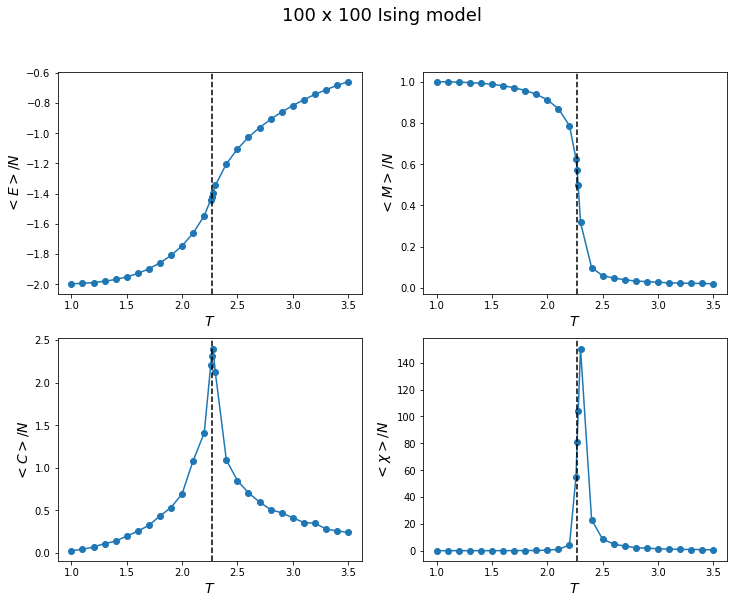

In [6]:
IsingMC(L= 100).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)

## RBM flows

### Flow from RBM trained with 29 different temperatures

First we load the trained RBM model.

In [2]:
rbm = RBM()
rbm = torch.load('RBM_trained_models/RBM_model_T_complete_nv10000_nh10000_lr1.0E-03_k1_bsize100_nepochs2000.pt')

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'rbm.RBM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


For the sake of completeness, we take a look at the weights distribution.

In [3]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

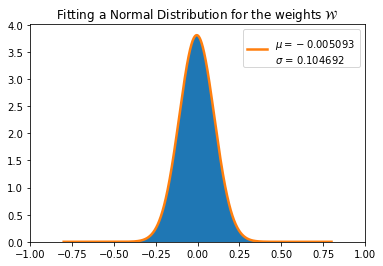

In [4]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, 
         bins= 1000, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_V, sigmaW_V = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_V, sigmaW_V) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_V, sigmaW_V ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.xlim([-1, 1])
plt.legend()
plt.show()

In [5]:
del W
torch.cuda.empty_cache()

#### Initial temperature: $T_0= 0$

In [8]:
n_states = 1000

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [9]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [10]:
with open('RBM_flows/rbm_flow_L100_ALL_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [6]:
with open('RBM_flows/rbm_flow_L100_ALL_Tin_zero_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [11]:
flow_ = [ x.cuda() for x in flow ]

In [7]:
flow_ = [ x.cpu() for x in flow ]
del flow
torch.cuda.empty_cache() 

Temperature measurement in the defined temperature scale.

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


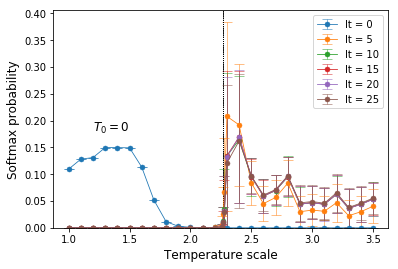

In [14]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 15,
            step= 5,
            Tzero= True,
            x_text= 1.1,
            y_text= 0.18,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

Without error bars:

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


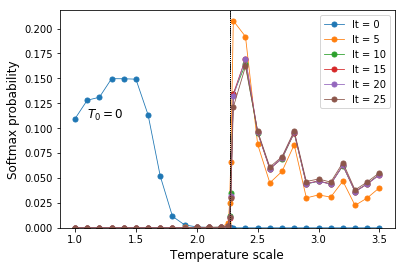

In [17]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 15,
            step= 5,
            Tzero= True,
            x_text= 1.1,
            y_text= 0.11,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper right',
            training_set= 'COMPLETE',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

#### Initial temperature: $T = \infty$

In [8]:
L = 100
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [9]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [10]:
with open('RBM_flows/rbm_flow_L100_ALL_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [8]:
with open('RBM_flows/rbm_flow_L100_ALL_Tin_inf_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [11]:
flow__ = [ x.cuda() for x in flow ]

In [9]:
flow__ = [ x.cpu() for x in flow ]
del flow
torch.cuda.empty_cache() 

Temperature measurement in the defined temperature scale.

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


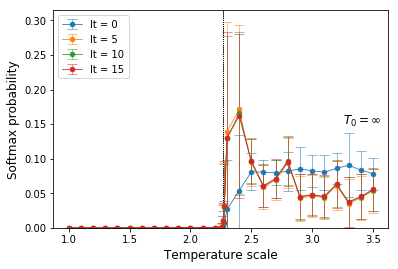

In [22]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 25,
            step= 5,
            Tzero= False,
            x_text= 3.25,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

Without error bars.

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


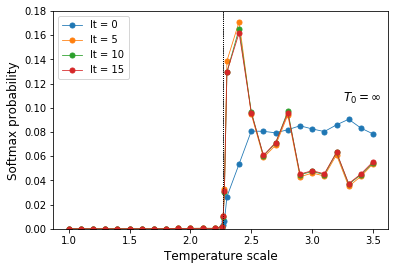

In [49]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 25,
            step= 5,
            Tzero= False,
            x_text= 3.25,
            y_text= 0.105,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper left',
            training_set= 'COMPLETE',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt',
            cpu= 'False')

#### Initial temperatures $T_0 = 0$ and $T_0 = \infty$ plots in the same figure

We can also take a look at the flows from $T_0 = 0$ and $T_0 = \infty$ in the same figure. 

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


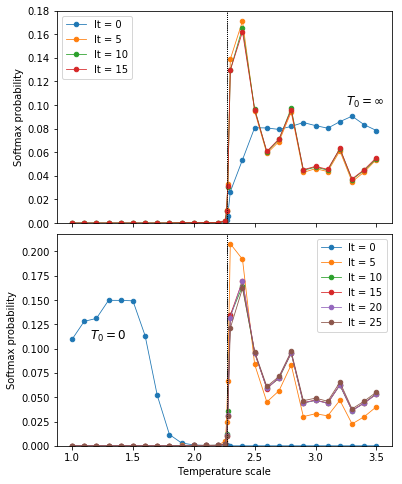

In [54]:
thermometer_joint_plot(flow_1= flow__,
                       flow_2= flow_,
                       ising_data= ising_data,
                       L= 100,
                       x1= 25,
                       x2= 15,
                       step1= 5,
                       step2= 5,
                       save= False,
                       Tzero1= False,
                       Tzero2= True,
                       x_text1= 3.25,
                       y_text1= 0.10,
                       x_text2= 1.15 ,
                       y_text2= 0.11,
                       errorbar1= False,
                       errorbar2= False,
                       publication= False,
                       loc_legend1= 'upper left',
                       loc_legend2= 'upper right',
                       training_set= 'COMPLETE',
                       NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt',
                       cpu= True)

We can also plot both flows from $T_0 = 0 $ and $ T_0 = \infty$ in the same figure with error bars on the first and last flows.

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


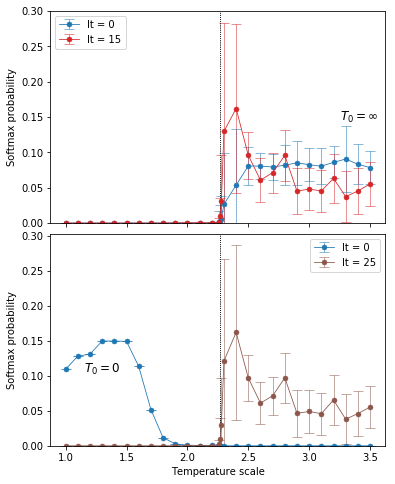

In [66]:
thermometer_joint_plot(flow_1= flow__,
                       flow_2= flow_,
                       ising_data= ising_data,
                       L= 100,
                       x1= 25,
                       x2= 15,
                       step1= 15,
                       step2= 25,
                       save= False,
                       Tzero1= False,
                       Tzero2= True,
                       x_text1= 3.25,
                       y_text1= 0.145,
                       x_text2= 1.15 ,
                       y_text2= 0.105,
                       errorbar1= True,
                       errorbar2= True,
                       publication= False,
                       ref_other_plot= True,
                       step1_ref_other= 5,
                       step2_ref_other= 5,
                       loc_legend1= 'upper left',
                       loc_legend2= 'upper right',
                       training_set= 'COMPLETE',
                       NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt',
                       cpu= True)

#### Magnetization dynamics

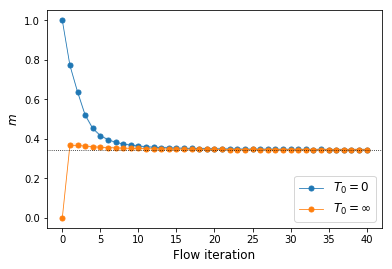

m^{*} = 0.344730


In [73]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= False,
              fill_error= True,
              Tzero= True,
              x = 0,
              save= True,
              publication= False)

The figure above was selected for publication, then (to set the predefined pattern) we run again the `magnetization` function with `publication= True`.

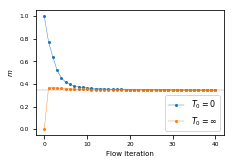

m^{*} = 0.344730


In [74]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= False,
              fill_error= True,
              Tzero= True,
              x = 0,
              save= True,
              publication= True)

### Flow from RBM trained only with $T=0$ and $ T = \infty$

In order to investigate the RBM flow in an extreme situation, we have trained the machine in an dataset composed only by frozen and random states.

It is crucial to note that, since the visible layer is always fed with an unidimensional vector (an array is transformed in a vector to be fed in the visible layer), the machine does not have any geometric information about the lattice in this case.

First, we load the model.

In [6]:
rbm = RBM()
rbm = torch.load('RBM_trained_models/RBM_model_T_zero_inf_nv10000_nh10000_lr1.0E-03_k1_bsize100_nepochs1000.pt',
                 map_location= 'cpu')

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'rbm.RBM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


For the sake of completeness, we take a look at the weights distribution.

In [7]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

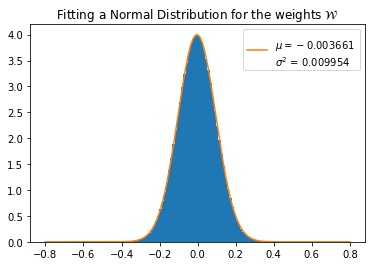

In [49]:
#W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))
W_ = W.numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, bins= 100, density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
mu_HL, sigma_HL = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, mu_HL, sigma_HL) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 1.5,
         label= '$\mu= %.6f$ \n$\sigma$ = %.6f' % (mu_HL, sigma_HL))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.legend()
plt.show()

In [ ]:
#W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))
W_ = W.numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, bins= 100, density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
mu_HL, sigma_HL = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, mu_HL, sigma_HL) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 1.5,
         label= '$\mu= %.6f$ \n$\sigma$ = %.6f' % (mu_HL, sigma_HL))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.legend()
plt.show()

#### Initial temperature: $T_0= 0$

In [7]:
n_states = 1000

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [8]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [20]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [75]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_zero_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

In [76]:
flow_ = [ x.cpu() for x in flow ]
del flow
torch.cuda.empty_cache()

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [9]:
flow_ = [ x.cuda() for x in flow ]

Temperature measurement in the defined temperature scale.

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


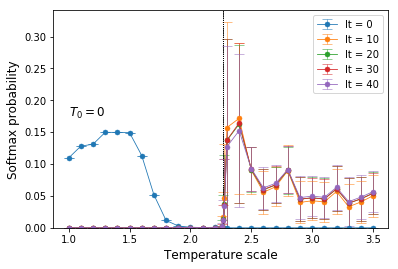

In [23]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 10,
            Tzero= True,
            x_text= 1.0,
            y_text= 0.175,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper right',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

Without error bars:

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


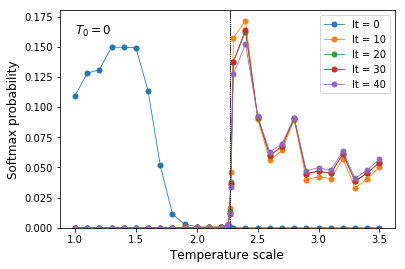

In [18]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 10,
            Tzero= True,
            x_text= 1.0,
            y_text= 0.16,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper right',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

In [21]:
del flow_
torch.cuda.empty_cache()

#### Initial temperature: $T_0 = \infty$

In [6]:
L = 100
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [9]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [16]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [77]:
with open('RBM_flows/rbm_flow_L100_ONLY_Tin_inf_it040.pkl', 'rb') as f:
    flow = pickle.load(f)

In [78]:
flow__ = [ x.cpu() for x in flow ]
del flow
torch.cuda.empty_cache()

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [20]:
flow__ = [ x.cuda() for x in flow ]

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


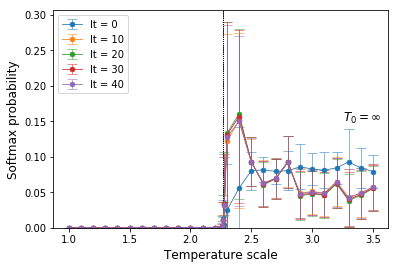

In [24]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 0,
            step= 10,
            Tzero= False,
            x_text= 3.25,
            y_text= 0.15,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

Without error bars:

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


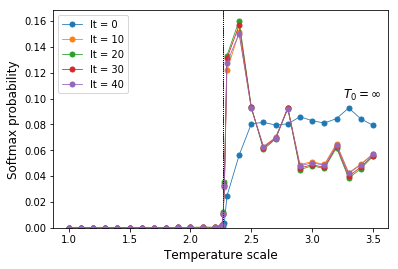

In [27]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 0,
            step= 10,
            Tzero= False,
            x_text= 3.25,
            y_text= 0.10,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper left',
            training_set= 'LOW_HIGH',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

#### Initial temperatures $T_0 = 0$ and $T_0 = \infty$ plots in the same figure

We can also take a look at the flows from $T_0 = 0$ and $T_0 = \infty$ in the same figure. 

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


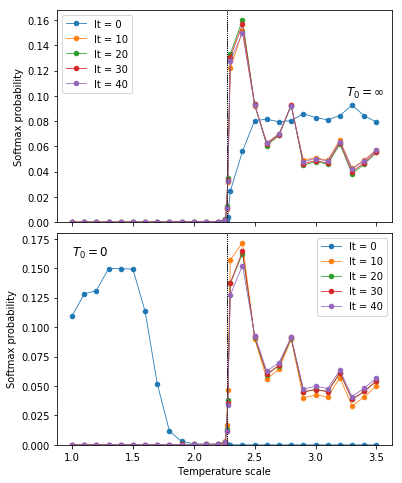

In [30]:
thermometer_joint_plot(flow_1= flow__,
                       flow_2= flow_,
                       ising_data= ising_data,
                       L= 100,
                       x1= 0,
                       x2= 0,
                       step1= 10,
                       step2= 10,
                       save= False,
                       Tzero1= False,
                       Tzero2= True,
                       x_text1= 3.25,
                       y_text1= 0.1,
                       x_text2= 1.0 ,
                       y_text2= 0.16,
                       errorbar1= False,
                       errorbar2= False,
                       publication= False,
                       loc_legend1= 'upper left',
                       loc_legend2= 'upper right',
                       training_set= 'LOW_HIGH',
                       NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

#### Magnetization dynamics

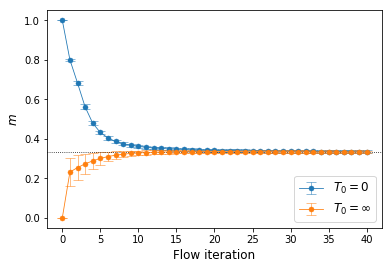

m^{*} = 0.333190


In [80]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= True,
              fill_error= False,
              Tzero= True,
              x = 0,
              save= False, 
              loc_legend= 'lower right',
              training_set= 'LOW_HIGH',
              publication= False)

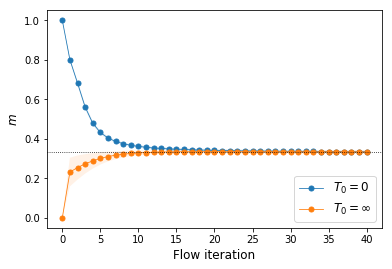

m^{*} = 0.333190


In [81]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= False,
              fill_error= True,
              Tzero= True,
              x = 0,
              save= False, 
              loc_legend= 'lower right',
              training_set= 'LOW_HIGH',
              publication= False)

## Flow from RBM trained  with 29 different temperatures (MEAN FIELD)

First we load the trained RBM model.

In [7]:
rbm = RBM()
rbm = torch.load('RBM_trained_models/RBM_model_T_complete_MF_nv10000_nh10000_lr1.0E-03_k1_bsize100_nepochs250.pt')

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'rbm.RBM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


### RBM flow

#### Initial temperature: $T_0= 0$

In [9]:
n_states = 200

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

In [10]:
flow = rbm.flow(n_it_flow= 45, vk= v0)

In [21]:
del flow

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [ ]:
with open('RBM_flows/rbm_flow_L100_MF_ALL_Tin_zero_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [11]:
flow_ = [ x.cuda() for x in flow ]

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


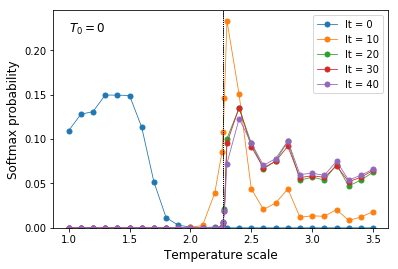

In [28]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 10,
            Tzero= True,
            x_text= 1.0,
            y_text= 0.22,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper right',
            training_set= 'MF',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


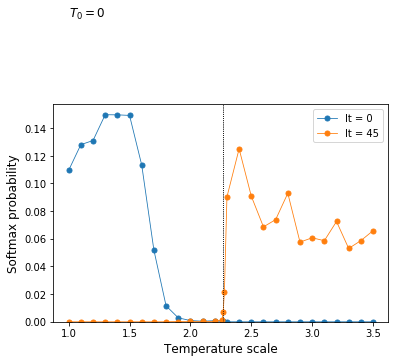

In [27]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 45,
            Tzero= True,
            x_text= 1.0,
            y_text= 0.22,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper right',
            training_set= 'MF',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

#### Initial temperature: $T_0 = \infty$

In [18]:
nstates = 1000

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(nstates - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

In [19]:
flow = rbm.flow(n_it_flow= 40, vk= v0)

Perhaps we will be needing this flow for further analysis, the we save it in a pickle file.

In [ ]:
with open('RBM_flows/rbm_flow_L100_MF_ALL_Tin_inf_it040.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [20]:
flow__ = [ x.cuda() for x in flow ]

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


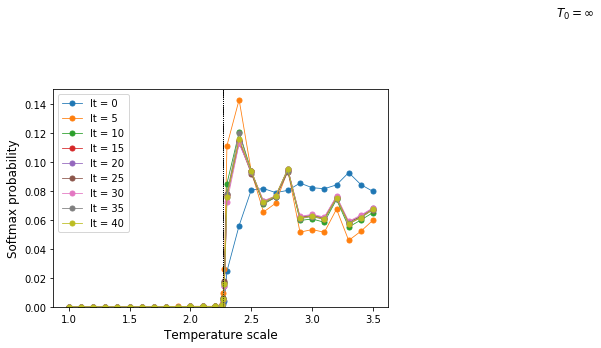

In [23]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= False,
            x_text= 5.0,
            y_text= 0.2,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper left',
            training_set= 'MF',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')



Once we have checked that the flow path towards the critical temperature does not depend on the geometry of the lattice, we investigate whether it depends or not on the specif values obtained by the training procedure.

## RBM Flow - Sampling from the weight distribution

### Annealed case

#### Initial temperature: $T= 0$

In [11]:
n_states = 1000

##### Initial State - T zero

v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)

mu = -0.001
sigma = np.sqrt(0.0015)

################################
    
flow = []
flow.append(v0)
n_it_flow = 20

for l in range(n_it_flow):
    
    W_ = nn.init.normal_(torch.empty(L*L, L*L),
                         mean= mu,
                         std= sigma)
    
    rbm_ = RBM(num_visible= L*L,
               num_hidden= L*L,
               W= W_,
               bias= False, 
               T= 1.0, 
               use_cuda= False)
    
    _, h = rbm_.v_to_h(v= v0)
    
    W_ = nn.init.normal_(torch.empty(L*L, L*L),
                         mean= mu,
                         std= sigma)
    
    rbm_ = RBM(num_visible= L*L,
               num_hidden= L*L,
               W= W_,
               bias= False, 
               T= 1.0, 
               use_cuda= False)
    
    _, flow_ = rbm_.h_to_v(h= h)
    
    flow.append(flow_)
    v0 = flow_.clone()

In [36]:
with open('RBM_flows/rbm_flow_L100_ANNEALED_Tin_zero_it020.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [39]:
with open('RBM_flows/rbm_flow_L100_ANNEALED_Tin_zero_it020.pkl', 'rb') as f:
    flow= pickle.load(f)

In [40]:
flow_ = [ x.cuda() for x in flow ]

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


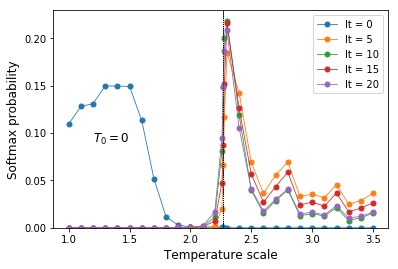

In [42]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= True,
            x_text= 1.2,
            y_text= 0.09,
            publication= False,
            errorbar= False,
            save= False,
            training_set= 'ANNEALED',
            loc_legend= 'upper right',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

With errorbars:

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


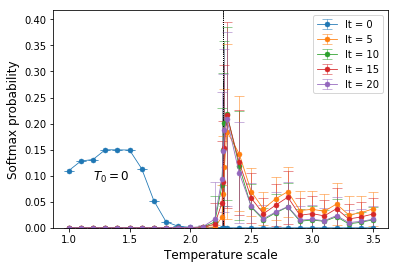

In [24]:
thermometer(flow_,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= True,
            x_text= 1.2,
            y_text= 0.09,
            publication= False,
            errorbar= True,
            save= False,
            training_set= 'ANNEALED',
            loc_legend= 'upper right',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

#### Initial temperature: $T= \infty$

In [28]:
n_states = 1000


mu = -0.001
sigma = np.sqrt(0.0015)

##### Initial State - T infinity

up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

up_down = torch.cat((up,down), 0)

v0 = up_down.reshape(1, up_down.shape[0])

for j in range(n_states - 1):
    
    v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
    v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )

################################
    
    
flow = []
flow.append(v0)
n_it_flow = 20

for l in range(n_it_flow):
    
    W_ = nn.init.normal_(torch.empty(L*L, L*L),
                         mean= mu,
                         std= sigma)
    
    rbm_ = RBM(num_visible= L*L,
               num_hidden= L*L,
               W= W_,
               bias= False, 
               T= 1.0, 
               use_cuda= False)
    
    _, h = rbm_.v_to_h(v= v0)
    
    W_ = nn.init.normal_(torch.empty(L*L, L*L),
                         mean= mu,
                         std= sigma)
    
    rbm_ = RBM(num_visible= L*L,
               num_hidden= L*L,
               W= W_,
               bias= False, 
               T= 1.0, 
               use_cuda= False)
    
    _, flow_ = rbm_.h_to_v(h= h)
    
    flow.append(flow_)
    v0 = flow_.clone()

In [32]:
with open('RBM_flows/rbm_flow_L100_ANNEALED_Tin_inf_it020.pkl', 'wb') as f:
    pickle.dump(flow, f)

In [29]:
flow__ = [ x.cuda() for x in flow ]

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


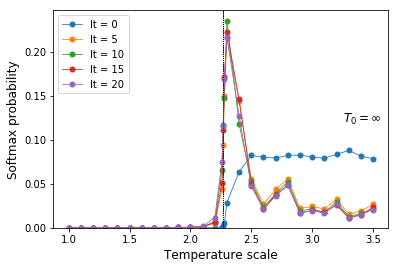

In [31]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= False,
            x_text= 3.25,
            y_text= 0.12,
            publication= False,
            errorbar= False,
            save= False,
            loc_legend= 'upper left',
            training_set= 'ANNEALED',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

With error bars:

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


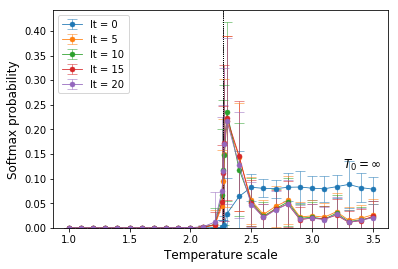

In [33]:
thermometer(flow__,
            ising_data,
            L= 100,
            x= 0,
            step= 5,
            Tzero= False,
            x_text= 3.25,
            y_text= 0.12,
            publication= False,
            errorbar= True,
            save= False,
            loc_legend= 'upper left',
            training_set= 'ANNEALED',
            NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


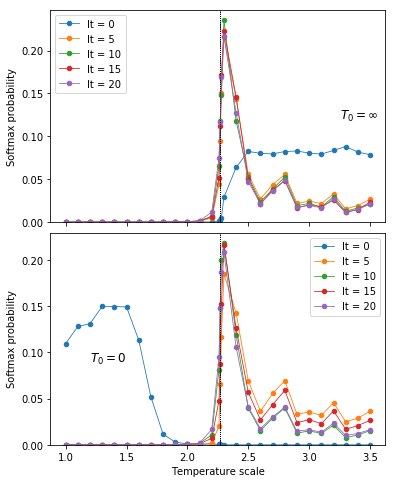

In [45]:
thermometer_joint_plot(flow_1= flow__,
                       flow_2= flow_,
                       ising_data= ising_data,
                       L= 100,
                       x1= 0,
                       x2= 0,
                       step1= 5,
                       step2= 5,
                       save= False,
                       Tzero1= False,
                       Tzero2= True,
                       x_text1= 3.25,
                       y_text1= 0.12,
                       x_text2= 1.2 ,
                       y_text2= 0.09,
                       errorbar1= False,
                       errorbar2= False,
                       publication= False,
                       loc_legend1= 'upper left',
                       loc_legend2= 'upper right',
                       training_set= 'ANNEALED',
                       NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt')

#### Magnetization dynamics

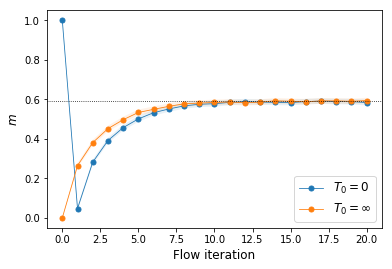

m^{*} = 0.593890


In [53]:
magnetization(flow_low= flow_,
              flow_high= flow__,
              L= 100,
              errorbar= False,
              fill_error= True,
              Tzero= True,
              training_set= 'ANNEALED',
              x = 0,
              save= False,
              publication= False)

### Annealed case: mean over many flows

In [15]:
def thermometer_ann(flow_,
                    ising_data,
                    L= 100,
                    save= False,
                    Tzero= True, 
                    x_text= 0,
                    y_text= 0.15,
                    publication= False,
                    Tc_MF= False,
                    it_f= 30, 
                    training_set= 'ANNEALED_AVG',
                    loc_legend= 'lower right',
                    NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt',
                    cpu= False):
    
    if Tc_MF:
        Tc_ = 2*2.0
    else:
        Tc_ = 2 / ( np.log(1 + np.sqrt(2)) )
        
    
    net = Net()
    if cpu:
        net = torch.load(NN_path, map_location= 'cpu')
    else:
        net = torch.load(NN_path)  
    
    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        
    else:
        markersize= 10.0
        linewidth= 0.8
        fontsize_l= 12.0
        fontsize_t= 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth= 0.5
        
    prediction0 = net(flow_[0])
      
    plt.plot(np.sort(ising_data['temp'].value_counts().index),
             prediction0.cpu().mean(dim=0).data.numpy(),
             marker= '.',
             markersize= markersize,
             linewidth= linewidth,
             label= 'It = %d' % 0 )
    

    
    pred_list = []
    
    for j in range(0, len(flow_)):
        
        prediction = net(flow_[j])
        
        
        pred_list.append(prediction.cpu().mean(dim=0).data.numpy())
        
        
        
        
    pred = np.array(pred_list)
    
    plt.plot(np.sort(ising_data['temp'].value_counts().index),
             np.mean(pred, axis= 0),
             marker= '.',
             markersize= markersize,
             linewidth= linewidth,
             label= 'It = %d' % it_f )
    
    plt.fill_between(np.sort(ising_data['temp'].value_counts().index), 
                     np.mean(pred, axis= 0) - np.std(pred, axis= 0),
                     np.mean(pred, axis= 0) + np.std(pred, axis= 0),
                     alpha= 0.1, 
                     color= 'C1')
        
       
    plt.axvline(x= Tc_, linestyle= ':', linewidth= 0.8, color= 'black')
      
    plt.xlabel('Temperature scale', fontsize= fontsize_l)
    plt.ylabel('Softmax probability', fontsize= fontsize_l)
        
        
    plt.legend(fontsize= fontsize_lg,
               loc= loc_legend)
    
    if Tzero:
        plt.text(x= x_text, y= y_text, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        plt.text(x= x_text, y= y_text, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    plt.ylim(0.0, plt.ylim()[1])
    
    if save:
        if Tzero:
            if publication:
                path_fig = 'figures/PUB_flow_L%d_Train%s_ONLY_Tin_zero.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
            else:
                path_fig = 'figures/flow_L%d_Train%s_ONLY_Tin_zero.pdf' % (L, training_set)
                plt.savefig(path_fig, bbox_inches='tight')
        else:
            if publication:
                path_fig = 'figures/PUB_flow_L%d_Train%s_ONLY_Tin_inf.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
            else:
                path_fig = 'figures/flow_L%d_ONLY_Train%s_Tin_inf.pdf' % (L, training_set)
                plt.savefig(path_fig , bbox_inches='tight')
                           
    plt.show()

In [23]:
def thermometer_joint_plot_ann(flow_1,
                               flow_2,
                               ising_data= None,
                               L= 100,
                               save= False,
                               Tzero1= True,
                               Tzero2= True,
                               x_text1= 0,
                               y_text1= 0.15,
                               x_text2= 0,
                               y_text2= 0.15,
                               it_f= 30,
                               publication= False,
                               training_set= 'ANNEALED_AVG',
                               loc_legend1= 'lower right',
                               loc_legend2= 'lower right',
                               NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt',
                               cpu= False):
    
    net = Net()
    if cpu:
        net = torch.load(NN_path, map_location= 'cpu')
    else:
        net = torch.load(NN_path) 
    
    if publication:
        fig = plt.figure(figsize=(3.375, 
                                  2*0.678*3.375))
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_ticks = 6.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        linewidth_v= 0.5
        
        if save:
            
            path_fig = 'figures/PUB_flow_L%d_Train%s_TinZERO_and_TinINF.pdf' % (L,
                                                                                training_set)                
        
    else:
        fig = plt.figure(figsize=(plt.rcParams.get('figure.figsize')[0],
                                  2*plt.rcParams.get('figure.figsize')[1]))
        markersize= 10.0
        linewidth= 0.8
        fontsize_l= 10.0
        fontsize_t= 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth= 0.5
        linewidth_v= 0.8
        
        if save:
            
            path_fig = 'figures/flow_L%d_Train%s_TinZERO_and_TinINF.pdf' % (L,
                                                                            training_set)   
 
        
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
        
    ### ax1 plot
    
    prediction0 = net(flow_1[0])
      
    ax1.plot(np.sort(ising_data['temp'].value_counts().index),
             prediction0.cpu().mean(dim=0).data.numpy(),
             marker= '.',
             markersize= markersize,
             linewidth= linewidth,
             label= 'It = %d' % 0 )
    
    pred_list = []
    
    for j in range(0, len(flow_1)):
        
        prediction = net(flow_1[j])
        
        
        pred_list.append(prediction.cpu().mean(dim=0).data.numpy())
        
        
    pred = np.array(pred_list)
    
    ax1.plot(np.sort(ising_data['temp'].value_counts().index),
             np.mean(pred, axis= 0),
             marker= '.',
             markersize= markersize,
             linewidth= linewidth,
             label= 'It = %d' % it_f )
    
    ax1.fill_between(np.sort(ising_data['temp'].value_counts().index), 
                     np.mean(pred, axis= 0) - np.std(pred, axis= 0),
                     np.mean(pred, axis= 0) + np.std(pred, axis= 0),
                     alpha= 0.1, 
                     color= 'C1')
        
        
    ax1.axvline(x= Tc_Ons, linestyle= ':', linewidth= linewidth_v, color= 'black')
     
    ax1.set_ylabel('Softmax probability', fontsize= fontsize_l)
        
    ax1.legend(fontsize= fontsize_lg,
               loc= loc_legend1)
    
    if Tzero1:
        ax1.text(x= x_text1, y= y_text1, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        ax1.text(x= x_text1, y= y_text1, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    ax1.set_ylim(0.0, ax1.set_ylim()[1])
    if publication:
        ax1.tick_params(axis="y", labelsize= fontsize_ticks)
        ax1.tick_params(axis="x", labelsize= fontsize_ticks)
    ax1.set_xticklabels([])
    
    ### ax2 plot
    
       
    prediction0 = net(flow_2[0])
      
    ax2.plot(np.sort(ising_data['temp'].value_counts().index),
             prediction0.cpu().mean(dim=0).data.numpy(),
             marker= '.',
             markersize= markersize,
             linewidth= linewidth,
             label= 'It = %d' % 0 )
    
    pred_list = []
    
    for j in range(0, len(flow_2)):
        
        prediction = net(flow_2[j])
        
        
        pred_list.append(prediction.cpu().mean(dim=0).data.numpy())
        
        
    pred = np.array(pred_list)
    
    ax2.plot(np.sort(ising_data['temp'].value_counts().index),
             np.mean(pred, axis= 0),
             marker= '.',
             markersize= markersize,
             linewidth= linewidth,
             label= 'It = %d' % it_f )
    
    ax2.fill_between(np.sort(ising_data['temp'].value_counts().index), 
                     np.mean(pred, axis= 0) - np.std(pred, axis= 0),
                     np.mean(pred, axis= 0) + np.std(pred, axis= 0),
                     alpha= 0.1, 
                     color= 'C1')
        
    
        
    ax2.axvline(x= Tc_Ons, linestyle= ':', linewidth= linewidth_v, color= 'black')
       
    ax2.set_ylabel('Softmax probability', fontsize= fontsize_l)
        
    ax2.legend(fontsize= fontsize_lg,
               loc= loc_legend2)
    
    if Tzero2:
        ax2.text(x= x_text2, y= y_text2, s= '$T_0 = 0$', fontsize= fontsize_t)
    else:
        ax2.text(x= x_text2, y= y_text2, s= '$T_0  =\infty$', fontsize= fontsize_t)
        
    ax2.set_ylim(0.0, ax2.set_ylim()[1])
    if publication:
        ax2.tick_params(axis="y", labelsize= fontsize_ticks)
        ax2.tick_params(axis="x", labelsize= fontsize_ticks)
                

    ax1.get_shared_x_axes().join(ax1, ax2)
    
    plt.subplots_adjust(hspace=.05)
    
    plt.xlabel('Temperature scale', fontsize= fontsize_l)
    
    if save:
        plt.savefig(path_fig , bbox_inches='tight')

    plt.show()

In [6]:
def flow_annealed_mean_last(n_states= 1000,
                            L= 100,
                            Tzero= False,
                            mu= -0.001,
                            sigma= np.sqrt(0.0015),
                            n_flows = 20,
                            n_it_flow= 20,
                            time_= False,
                            use_cuda= False):
    
    ##########################
        
    if Tzero:
        ##### Initial State - T zero
        v0 = nn.init.constant_(torch.empty(n_states, L*L),
                       val= 1.0)
    else:
        ##### Initial State - T infinity

        up = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 1.0)
        down = nn.init.constant_(torch.empty(int(L*L/2)),
                                     val= 0.0)

        up_down = torch.cat((up,down), 0)

        v0 = up_down.reshape(1, up_down.shape[0])

        for j in range(n_states - 1):
            
            v0_ = up_down[torch.randperm(up_down.shape[0]) ]
    
            v0 = torch.cat( ( v0, v0_.reshape(1, v0_.shape[0])), 0 )
        
    ##########################
        
    flow = []
    flow.append(v0)
    
    v0_fixed = v0.clone()
    
    for j in range(n_flows):
        
        t0 = time.time()
        
        v0 = v0_fixed.clone()
              
        for l in range(n_it_flow):
            
               
            W_ = nn.init.normal_(torch.empty(L*L, L*L),
                                 mean= mu,
                                 std= sigma)
    
            rbm_ = RBM(num_visible= L*L,
                       num_hidden= L*L,
                       W= W_,
                       bias= False, 
                       T= 1.0, 
                       use_cuda= use_cuda)
    
            _, h = rbm_.v_to_h(v= v0)
    
            W_ = nn.init.normal_(torch.empty(L*L, L*L),
                                 mean= mu,
                                 std= sigma)
    
            rbm_ = RBM(num_visible= L*L,
                       num_hidden= L*L,
                       W= W_,
                       bias= False, 
                       T= 1.0, 
                       use_cuda= use_cuda)
    
            _, flow_ = rbm_.h_to_v(h= h)
    
            v0 = flow_.clone()
            
        flow.append(flow_)
        del flow_
        del v0
        
        if time_:
            t1 = time.time()
            print('n_flow = %d - time: %.3f s' % (j+1, t1-t0))
        
    return flow

#### Initial temperature $T=\infty$

In [7]:
flow_ann = flow_annealed_mean_last(n_states= 1000,
                                   L= 100,
                                   Tzero= False,
                                   mu= -0.001,
                                   sigma= np.sqrt(0.0015),
                                   n_flows = 50,
                                   n_it_flow= 30,
                                   time_= True,
                                   use_cuda= False)

n_flow = 1 - time: 130.051 s
n_flow = 2 - time: 130.806 s
n_flow = 3 - time: 128.487 s
n_flow = 4 - time: 130.713 s
n_flow = 5 - time: 129.756 s
n_flow = 6 - time: 129.721 s
n_flow = 7 - time: 127.813 s
n_flow = 8 - time: 128.225 s
n_flow = 9 - time: 131.116 s
n_flow = 10 - time: 133.340 s
n_flow = 11 - time: 129.544 s
n_flow = 12 - time: 129.216 s
n_flow = 13 - time: 129.135 s
n_flow = 14 - time: 128.253 s
n_flow = 15 - time: 127.853 s
n_flow = 16 - time: 128.582 s
n_flow = 17 - time: 128.599 s
n_flow = 18 - time: 132.752 s
n_flow = 19 - time: 132.505 s
n_flow = 20 - time: 131.335 s
n_flow = 21 - time: 129.224 s
n_flow = 22 - time: 130.548 s
n_flow = 23 - time: 130.286 s
n_flow = 24 - time: 129.746 s
n_flow = 25 - time: 129.575 s
n_flow = 26 - time: 129.688 s
n_flow = 27 - time: 129.563 s
n_flow = 28 - time: 131.725 s
n_flow = 29 - time: 128.099 s
n_flow = 30 - time: 127.768 s
n_flow = 31 - time: 128.503 s
n_flow = 32 - time: 128.378 s
n_flow = 33 - time: 128.737 s
n_flow = 34 - time:

In [8]:
with open('RBM_flows/rbm_flow_L100_ANNEALED_AVER_Tin_inf_it030_flows_050.pkl', 'wb') as f:
    pickle.dump(flow_ann, f)

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


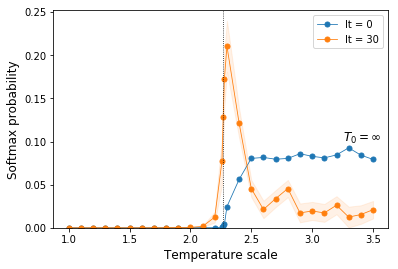

In [16]:
thermometer_ann(flow_ann,
                ising_data,
                L= 100,
                save= False,
                Tzero= False, 
                x_text= 3.25,
                y_text= 0.10,
                publication= False,
                Tc_MF= False,
                it_f= 30,
                training_set= 'ANNEALED_AVG',
                loc_legend= 'upper right',
                NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt',
                cpu= True)

#### Initial temperature $T=0$

In [9]:
flow_ann_ = flow_annealed_mean_last(n_states= 1000,
                                   L= 100,
                                   Tzero= True,
                                   mu= -0.001,
                                   sigma= np.sqrt(0.0015),
                                   n_flows = 50,
                                   n_it_flow= 30,
                                   time_= True,
                                   use_cuda= False)

n_flow = 1 - time: 139.757 s
n_flow = 2 - time: 140.570 s
n_flow = 3 - time: 140.095 s
n_flow = 4 - time: 147.843 s
n_flow = 5 - time: 132.115 s
n_flow = 6 - time: 130.120 s
n_flow = 7 - time: 129.696 s
n_flow = 8 - time: 129.251 s
n_flow = 9 - time: 129.993 s
n_flow = 10 - time: 132.745 s
n_flow = 11 - time: 131.836 s
n_flow = 12 - time: 133.774 s
n_flow = 13 - time: 131.318 s
n_flow = 14 - time: 129.917 s
n_flow = 15 - time: 127.612 s
n_flow = 16 - time: 131.635 s
n_flow = 17 - time: 133.213 s
n_flow = 18 - time: 129.935 s
n_flow = 19 - time: 131.107 s
n_flow = 20 - time: 130.149 s
n_flow = 21 - time: 130.233 s
n_flow = 22 - time: 130.615 s
n_flow = 23 - time: 131.276 s
n_flow = 24 - time: 130.409 s
n_flow = 25 - time: 130.419 s
n_flow = 26 - time: 128.079 s
n_flow = 27 - time: 128.333 s
n_flow = 28 - time: 130.675 s
n_flow = 29 - time: 131.279 s
n_flow = 30 - time: 130.536 s
n_flow = 31 - time: 129.352 s
n_flow = 32 - time: 128.576 s
n_flow = 33 - time: 129.525 s
n_flow = 34 - time:

In [10]:
with open('RBM_flows/rbm_flow_L100_ANNEALED_AVER_Tin_zero_it030_flows_050.pkl', 'wb') as f:
    pickle.dump(flow_ann_, f)

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


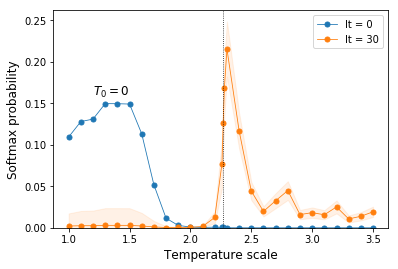

In [18]:
thermometer_ann(flow_ann_,
                ising_data,
                L= 100,
                save= False,
                Tzero= True, 
                x_text= 1.2,
                y_text= 0.16,
                publication= False,
                Tc_MF= False,
                it_f= 30,
                training_set= 'ANNEALED_AVG',
                loc_legend= 'upper right',
                NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt',
                cpu= True)

#### Initial temperatures $T_0 = 0$ and $T_0 = \infty$ plots in the same figure

We can also take a look at the flows from $T_0 = 0$ and $T_0 = \infty$ in the same figure. 

/home/rodrigo/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'net.Net' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


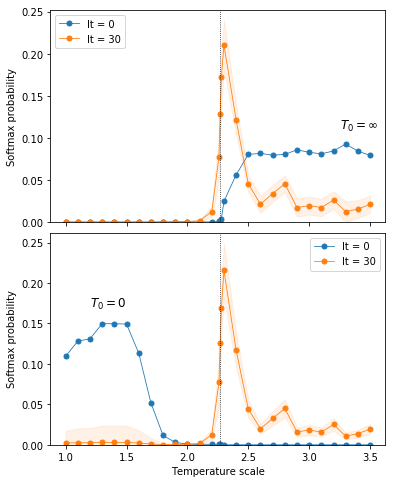

In [24]:
thermometer_joint_plot_ann(flow_ann,
                           flow_ann_,
                           ising_data= ising_data,
                           L= 100,
                           save= False,
                           Tzero1= False,
                           Tzero2= True,
                           x_text1= 3.25,
                           y_text1= 0.11,
                           x_text2= 1.2,
                           y_text2= 0.17,
                           publication= False,
                           it_f= 30,
                           training_set= 'ANNEALED_AVG',
                           loc_legend1= 'upper left',
                           loc_legend2= 'upper right',
                           NN_path= 'NN_trained_models/L100_NN_Ising2D_MC.pt',
                           cpu= True)